**rajvi using steph's code**

In [1]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium
from pyproj import Geod

In [2]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
api = MapboxAPI()

In [4]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii = branchRadii.set_crs('EPSG:4326')
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

for i in range(branchRadii.shape[0]):
    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 20)
    branchRadii.loc[i,'geometry'] = shape(api_response)

branchRadii = branchRadii.set_index('BRANCH')
#api_response = api.get_data((branchRadii.loc['Altgeld','LATITUDE'],branchRadii.loc['Altgeld','LONGITUDE']), 20)
#branchRadii.loc['Altgeld','geometry'] = shape(api_response)

/tmp/ipykernel_2101735/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_2101735/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


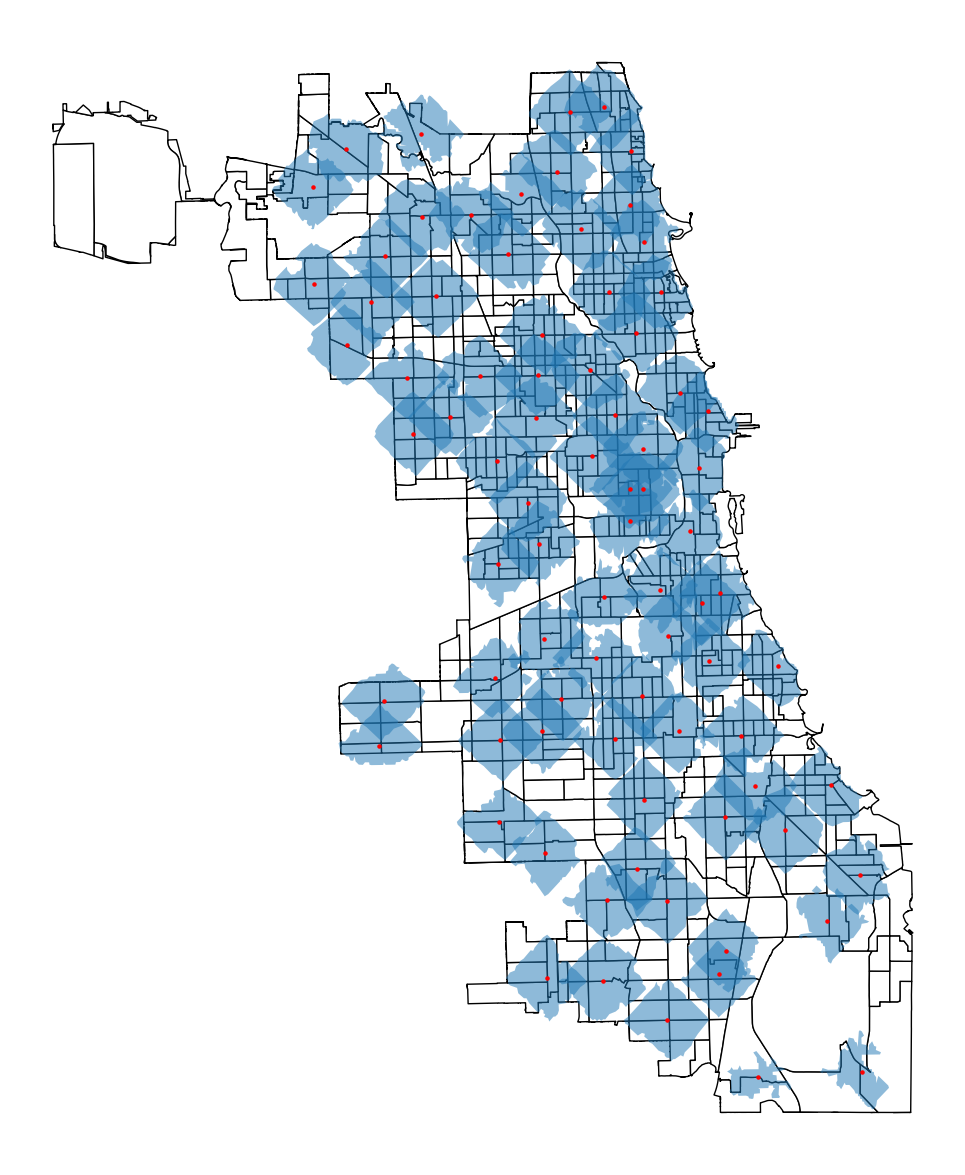

In [6]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")
    #branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:32633")

fig, ax = plt.subplots(1, figsize=(15, 15))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);


In [8]:
oneLib=pd.DataFrame
oneLib = pd.DataFrame(columns=['Census Tract','geometry'])
areaCalculations = pd.DataFrame(columns=['Census Tract','geometry'])
oneLib.reset_index(inplace = True)

# for loop to make dataframe of overlapping census tracts with the names of each census tract and polygon of area covered
# for loop also adds to new data frame which is collecting the name and geometry of the entire census tract that is partially or fully covered by
# the radius

geod=Geod(ellps='WGS84')
censusAreas = []


for index, row in censusTracts.iterrows():
    #print((branchRadii.intersection(row['geometry']))[0])
    oneBranch = gpd.GeoDataFrame({'geometry': [branchRadii.loc['Sulzer Regional','geometry']]})
    if ((oneBranch.intersection(row['geometry']))[0]).is_empty:
        empty=[]
        empty.append("none")
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(oneBranch.intersection(row['geometry'])[0])]}, index=[0])
        oneLib=pd.concat([oneLib,temp])
        geomTemp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(row['geometry'])]})
        areaCalculations = pd.concat([areaCalculations, geomTemp])


for index, row in areaCalculations.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    censusAreas.append(poly_area)
    
areaCalculations['calculated area'] = censusAreas
areaCalculations.reset_index(inplace = True)

/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersectio

In [9]:
areaCalculations

,index,Census Tract,geometry,calculated area
0,0,17031843700,"POLYGON ((-87.696809 41.950068, -87.696809 41....",1.266938
1,0,17031050500,"POLYGON ((-87.688223 41.954034, -87.687493 41....",0.652578
2,0,17031050600,"POLYGON ((-87.678268 41.954167, -87.677858 41....",0.332315
3,0,17031060300,"POLYGON ((-87.673563 41.954228, -87.672994 41....",0.319844
4,0,17031060200,"POLYGON ((-87.673665 41.96153, -87.673196 41.9...",0.318278
5,0,17031060100,"POLYGON ((-87.668951 41.961597, -87.668483 41....",0.325546
6,0,17031830700,"POLYGON ((-87.66575 41.961636, -87.665459 41.9...",0.869930
7,0,17031031900,"POLYGON ((-87.673764 41.965173, -87.673294 41....",0.257669
8,0,17031031700,"POLYGON ((-87.667293 41.968907, -87.667237 41....",0.477476
9,0,17031031800,"POLYGON ((-87.673858 41.968825, -87.673389 41....",0.235148


In [10]:

# convert oneLib to geodata frame and reasssign to crs used for area calculations (by default, its 4326 geometries)
oneLib = gpd.GeoDataFrame(oneLib, geometry="geometry")
oneLib = oneLib.set_crs(crs = 'epsg:4326')

oneLib.reset_index(inplace = True)

geod=Geod(ellps='WGS84')

overlappingAreas = []

for index, row in oneLib.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    overlappingAreas.append(poly_area)

oneLib['Area Within Radius']= overlappingAreas
oneLib['census Area'] = areaCalculations['calculated area']

# using Geod method with WGS84 and espg:4326 gives us area in DEGREES not meters so the proportion is accurate but 
# the actual area values you have to convert to a different crs to be useful as distances



In [11]:
print(oneLib.crs)

epsg:4326


In [12]:
oneLib = oneLib.drop(columns='level_0')
oneLib['Percent Overlap'] = oneLib['Area Within Radius']/oneLib['census Area']

In [13]:
oneLib = oneLib.drop(columns='index')
oneLib

,Census Tract,geometry,Area Within Radius,census Area,Percent Overlap
0,17031843700,"POLYGON ((-87.68869 41.95026, -87.69270 41.953...",0.091182,1.266938,0.071971
1,17031050500,"POLYGON ((-87.67870 41.94854, -87.68070 41.949...",0.453525,0.652578,0.694974
2,17031050600,"POLYGON ((-87.67517 41.94944, -87.67860 41.948...",0.221014,0.332315,0.665076
3,17031060300,"POLYGON ((-87.67138 41.95397, -87.67281 41.953...",0.029952,0.319844,0.093645
4,17031060200,"POLYGON ((-87.66953 41.95697, -87.67174 41.954...",0.272044,0.318278,0.854737
5,17031060100,"POLYGON ((-87.66574 41.96097, -87.66853 41.958...",0.062198,0.325546,0.191058
6,17031830700,"POLYGON ((-87.66573 41.96102, -87.66579 41.961...",0.001089,0.869930,0.001252
7,17031031900,"POLYGON ((-87.66670 41.96509, -87.66666 41.964...",0.257501,0.257669,0.999350
8,17031031700,"POLYGON ((-87.66670 41.96509, -87.66551 41.963...",0.022176,0.477476,0.046443
9,17031031800,"POLYGON ((-87.67193 41.96774, -87.67069 41.968...",0.152481,0.235148,0.648447


In [16]:
sulzerCensusOverlap20Walking1 = oneLib.copy(deep=True)
sulzerCensusOverlap20Walking1.to_csv('../individual lib census/sulzerCensusOverlap20Walking1.csv')

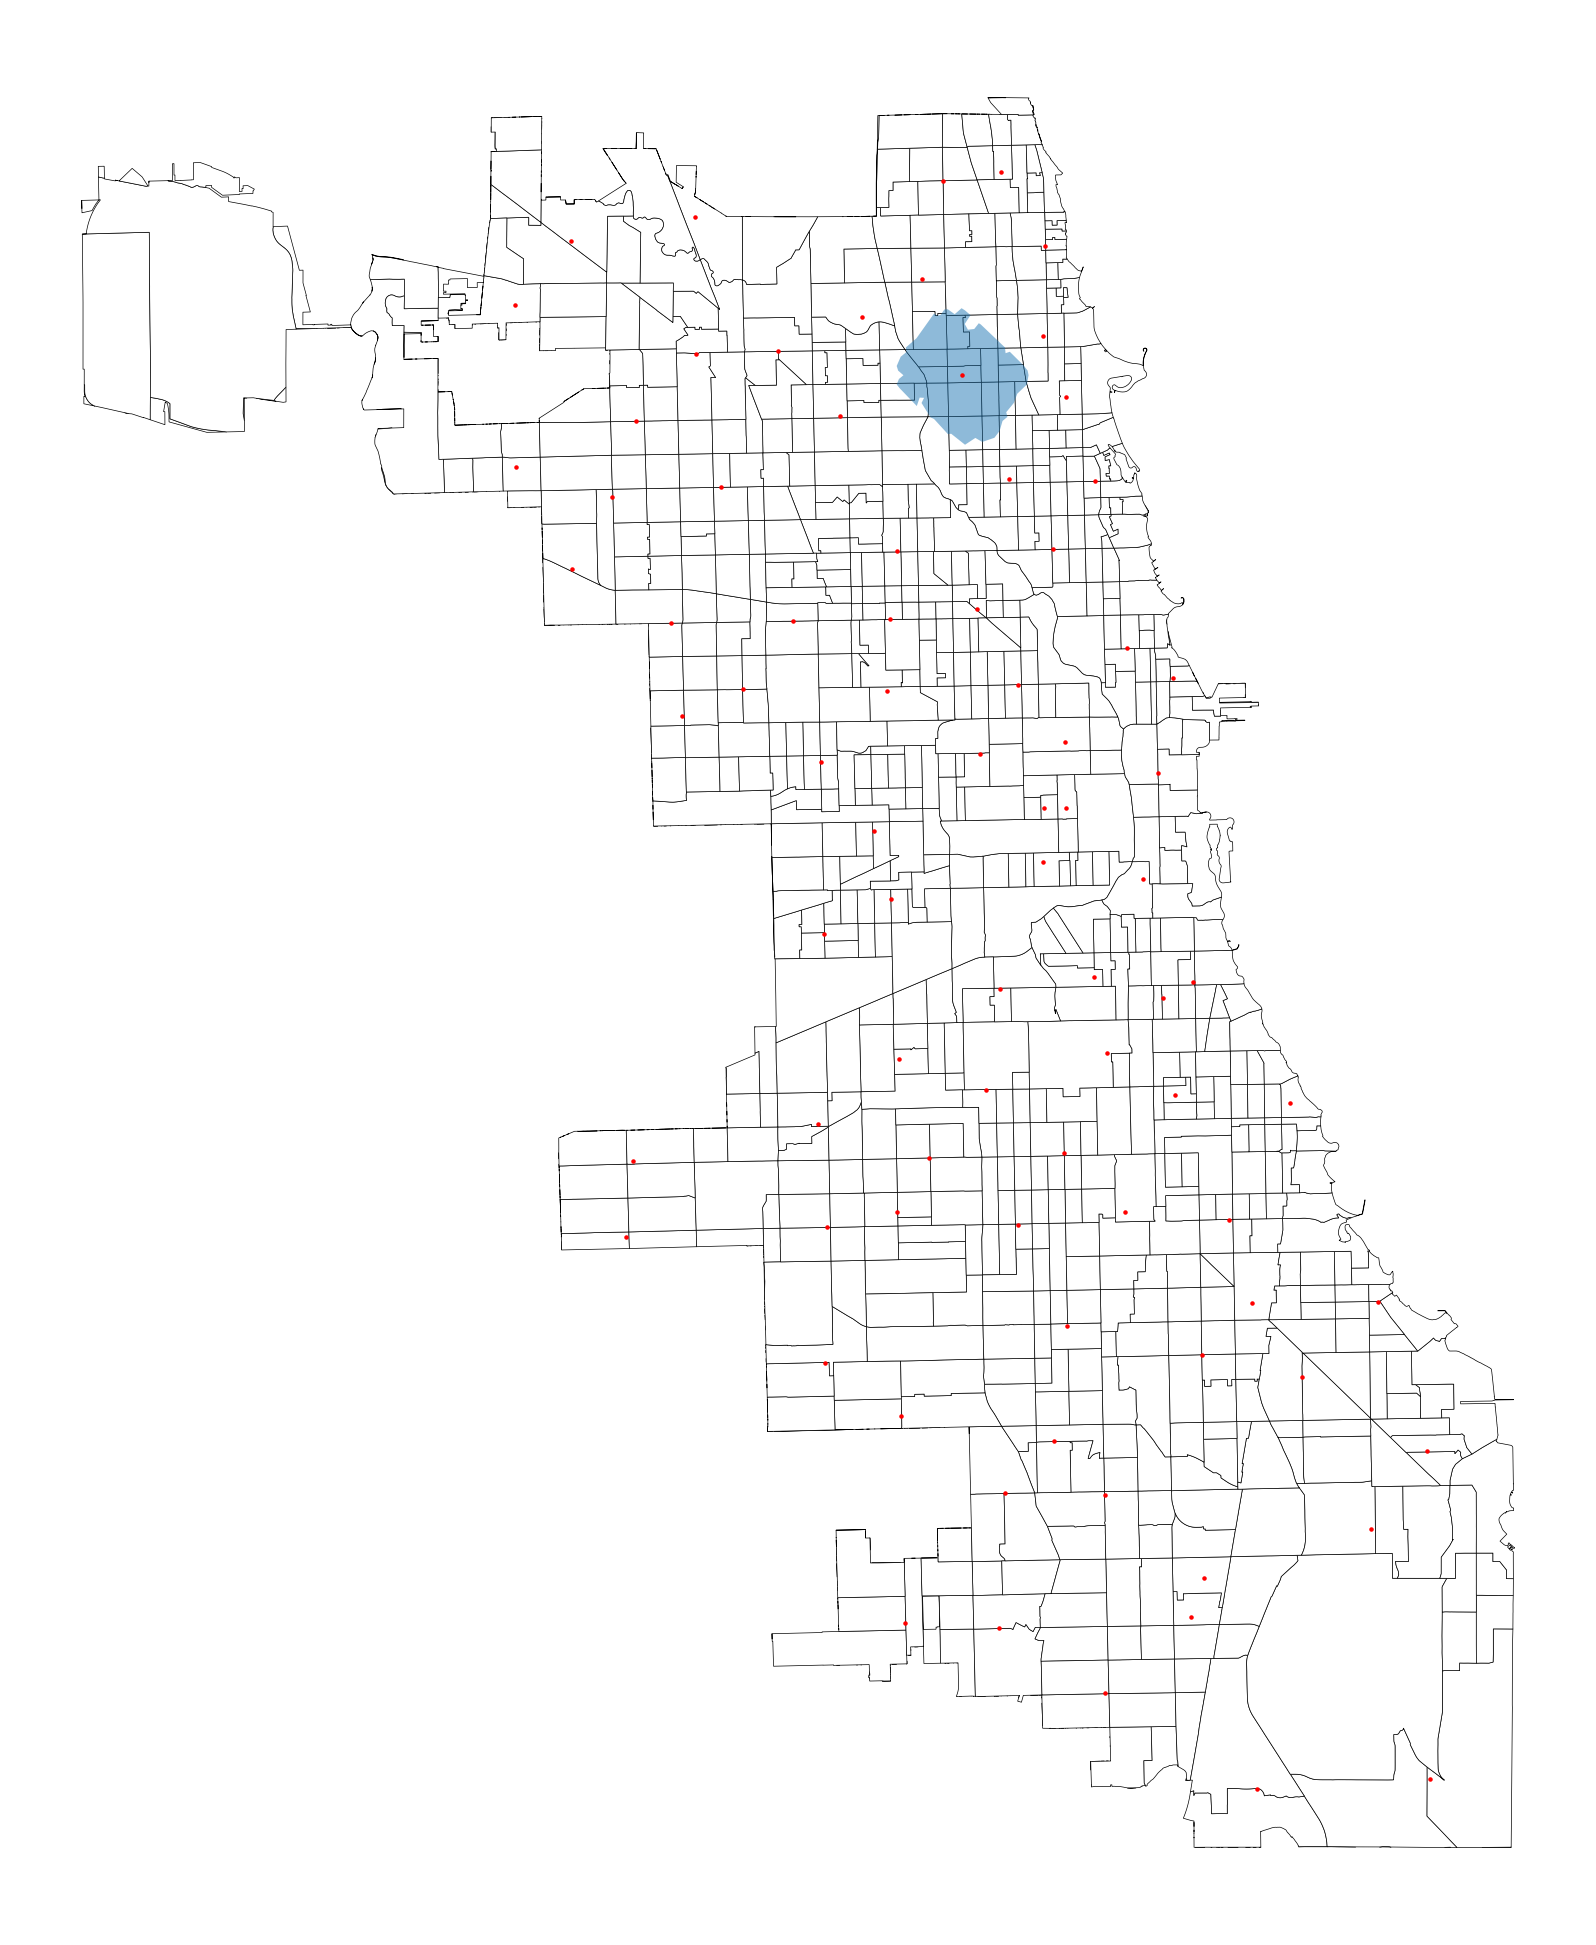

In [15]:
fig, ax = plt.subplots(1, figsize=(25, 25))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black', linewidth=.5)
ax.axis('off')

altgeldCensusOverlap20Walking1.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

